In [2]:
import pyparax as parax
import numpy as np 
import pandas as pd
import scipy as sp
from math import pi
import matplotlib.pyplot as plt
import cmath
from scipy.optimize import leastsq

In [114]:
phase_field_center = np.unwrap(np.angle(np.loadtxt('E_20.csv',delimiter=',',dtype=complex)))
pmf_phase = phase_field_center/np.sum(phase_field_center)

Text(0.5, 1.0, 'Unwrapped Phase of Unimodal Sample')

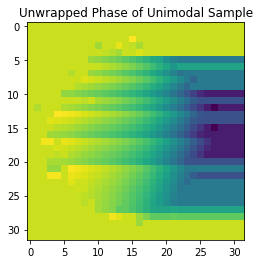

In [734]:
plt.imshow(np.unwrap(np.angle(field_center)));
plt.title('Unwrapped Phase of Unimodal Sample')

Text(0.5, 1.0, 'phase')

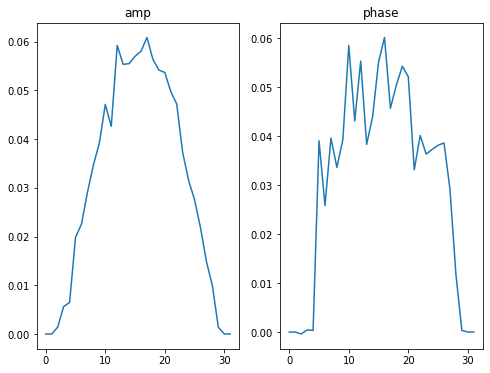

In [735]:
# We'll do a one dimensional example for proof
field_center = np.loadtxt('E_20.csv',delimiter=',',dtype=complex)
field_center = field_center[20-16:20+16,43-16:43+16]
abs_field_center = np.abs(field_center)
pmf_abs = abs_field_center/np.sum(abs_field_center)
marg_x_abs = np.sum(pmf_abs,axis=1)
phase_field_center = np.unwrap(np.angle(field_center))
pmf_phase = phase_field_center/np.sum(phase_field_center)
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(marg_x_abs)
plt.title('amp')
plt.subplot(1,2,2)
plt.plot(np.sum(pmf_phase,axis=1))
plt.title('phase')

In [736]:
marg_x = marg_x_abs*np.exp(1j*np.sum(pmf_phase,axis=0))

In [737]:
# We want a linear convolution to understand what the result is and then a circular convolution to understand the difference.
# Important to note how these are done
a = [1,2,2]
b = [1,2,3]
np.convolve(a,b)

array([ 1,  4,  9, 10,  6])

In [738]:
# via circular convolution, we have to use N1+N2-1 extenstion via padding and roll by N1 where N1<N2 or N1=N2
from scipy.ndimage import convolve
a = [1,2,2,0,0]
b = [1,2,3,0,0]
np.roll(convolve(a,b,mode='wrap'),1)

array([ 4,  9, 10,  6,  1])

In [739]:
lambda_ = 1.3e-10
pitch = 3e-4/64

In [740]:
def IR_func(z,x):
    return np.exp(1j*2*pi*z/lambda_)/np.sqrt(1j*lambda_*z)*np.exp(1j*pi*x**2/(lambda_*z))

def Transf_func(z,fx):
    return np.exp(1j*2*pi*z/lambda_)/np.sqrt(1j*lambda_*z)*np.exp(-1j*pi*lambda_*z*fx**2)

In [741]:
z = 28*pitch**2/lambda_
z

4.732572115384615

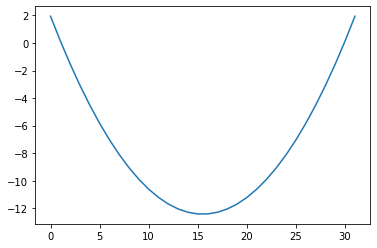

In [742]:
x = np.linspace(-pitch*len(marg_x)/2,pitch*len(marg_x)/2,len(marg_x))
plt.plot(np.unwrap(np.angle(IR_func(2*z,x))))

In [743]:
freqs = np.fft.fftshift(np.fft.fftfreq(2*len(marg_x)-1,pitch))
H_bar = Transf_func(2*z,freqs)

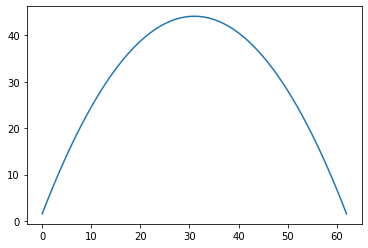

In [744]:
plt.plot(np.unwrap(np.angle(H_bar)))

In [745]:
h = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(H_bar)))

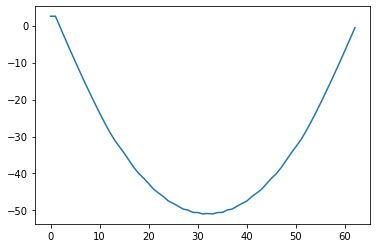

In [746]:
plt.plot(np.unwrap(np.angle(h)))

In [747]:
# Direct linear as a circular
marg_x_circ_padded = np.concatenate((marg_x,np.zeros(len(marg_x))))
IR_func_padded = 1j*np.zeros(2*len(marg_x))
IR_func_padded[len_x//2:len_x + len_x//2] = IR_func(z*2,x)
u_tilde = np.roll(convolve(marg_x_circ_padded,IR_func_padded),len(marg_x)//2)
#u_tilde = np.convolve(marg_x,IR_func(z*2,x))

Text(0.5, 1.0, 'phase direct linear')

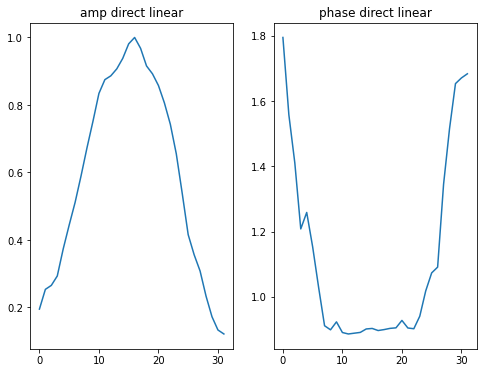

In [748]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(np.abs(u_tilde[len_x//2:len_x + len_x//2])/np.max(np.abs(u_tilde[len_x//2:len_x + len_x//2])))
plt.title('amp direct linear')
plt.subplot(1,2,2)
plt.plot(np.angle((u_tilde[len_x//2:len_x + len_x//2])))
plt.title('phase direct linear')

In [749]:
# Fourier transf, i.e. circular conv
len_x = len(marg_x)
marg_x_padded = 1j*np.zeros(2*len_x-1)
marg_x_padded[len_x//2:len_x + len_x//2] = marg_x
U = np.fft.fftshift(np.fft.fft(np.fft.fftshift(marg_x_padded)))*H_bar
u_tilde_fft = np.fft.ifftshift(np.fft.ifft(np.fft.ifftshift(U)))

Text(0.5, 1.0, 'phase fft')

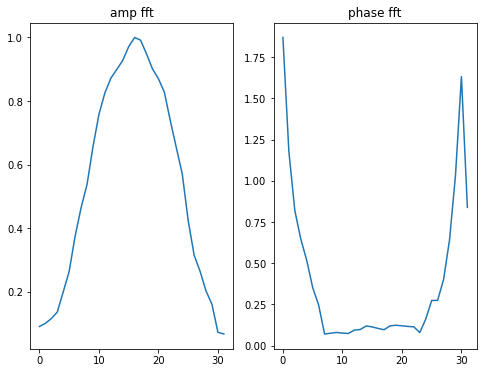

In [750]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(np.abs(u_tilde_fft[len_x//2:len_x + len_x//2])/np.max(np.abs(u_tilde_fft[len_x//2:len_x + len_x//2])))
plt.title('amp fft')
plt.subplot(1,2,2)
plt.plot(np.angle((u_tilde_fft[len_x//2:len_x + len_x//2])))
plt.title('phase fft')

In [751]:
# Inverse fourier transferred linear conv
marg_x_circ_padded = np.concatenate((marg_x,np.zeros(len(marg_x))))
#u_tilde_ifft_linear = np.convolve(marg_x,h)
u_tilde_ifft_linear = np.roll(convolve(marg_x_circ_padded,h),len(marg_x)//2)[len_x//2:len_x + len_x//2]

Text(0.5, 1.0, 'phase ifft linear')

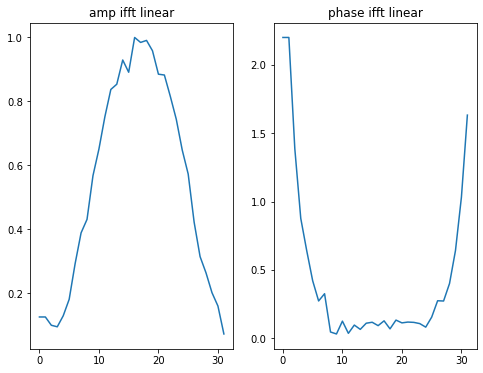

In [753]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(np.abs(u_tilde_ifft_linear)/np.max(np.abs(u_tilde_ifft_linear)))
plt.title('amp ifft linear')
plt.subplot(1,2,2)
plt.plot(np.angle((u_tilde_ifft_linear)))
plt.title('phase ifft linear')

In [733]:
# Numerical Integration 
from scipy.interpolate import CubicSpline
import scipy.integrate as integrate

u_spline = CubicSpline(np.linspace(-pitch*len(marg_x)/2,pitch*len(marg_x)/2,len(marg_x)),marg_x,bc_type='natural')

int_pitch = np.sqrt(lambda_*z/(2*len(marg_x)))

def fres_integrand_real(x,X):
    return np.real(u_spline(x))*np.cos(pi/(lambda_*z)*(X-x))

def fres_integrand_imag(x,X):
    return np.imag(u_spline(x))*np.sin(pi/(lambda_*z)*(X-x))

X_arr = np.linspace(-pitch*len(marg_x),pitch*len(marg_x),2*len(marg_x))

output_field_real = [integrate.quad(fres_integrand_real,-pitch*len(marg_x)/2,pitch*len(marg_x)/2,args=(X)) for X in X_arr]

output_field_imag = [integrate.quad(fres_integrand_imag,-pitch*len(marg_x)/2,pitch*len(marg_x)/2,args=(X)) for X in X_arr]


/tmp/ipykernel_70179/1966737484.py:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  output_field_real = [integrate.quad(fres_integrand_real,-pitch*len(marg_x)/2,pitch*len(marg_x)/2,args=(X)) for X in X_arr]
/tmp/ipykernel_70179/1966737484.py:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  output_field_real = [integrate.quad(fres_integrand_real,-pitch*len(marg_x)/2,pitch*len(marg_x)/2,args=(X)) for X in X_arr]
/tmp/ipykernel_70179/1966737484.py:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the

In [694]:
output_field_real

[(2.697378785102191e-08, 3.2247236422679085e-07),
 (2.201905508620632e-08, 5.154992504126904e-07),
 (1.9103594183135617e-08, 5.378026387553256e-07),
 (1.694809963958878e-08, 6.195600907470232e-07),
 (1.5149532339609697e-08, 5.106168512579454e-07),
 (1.3541617964906707e-08, 5.891906206179267e-07),
 (1.2044089988626714e-08, 6.659825686528194e-07),
 (1.061412919387647e-08, 7.410523042620942e-07),
 (9.227377733317905e-09, 8.143261442701789e-07),
 (7.86944844952354e-09, 8.856852747882201e-07),
 (6.5317300537379475e-09, 9.549941162391576e-07),
 (1.9591242886510173e-08, 1.007729350190323e-06),
 (3.8988934119247455e-09, 1.0868954778150868e-06),
 (-7.038198725722922e-09, 2.979058126387084e-06),
 (1.3745702108875071e-08, 1.1964739834643389e-06),
 (1.4642375411475273e-08, 1.2512615321557442e-06),
 (1.395977607673929e-08, 1.3047739547096727e-06),
 (1.3255143428194535e-08, 1.3553351569301608e-06),
 (1.2529011179424193e-08, 1.4028323475524212e-06),
 (1.1782162207339141e-08, 1.447159377409507e-06),
 

In [695]:
output_field = np.exp(1j*2*pi*z/lambda_)/np.sqrt(1j*lambda_*z)*(np.array(output_field_real)*1j*np.array(output_field_imag))

Text(0.5, 1.0, 'phase numerical int')

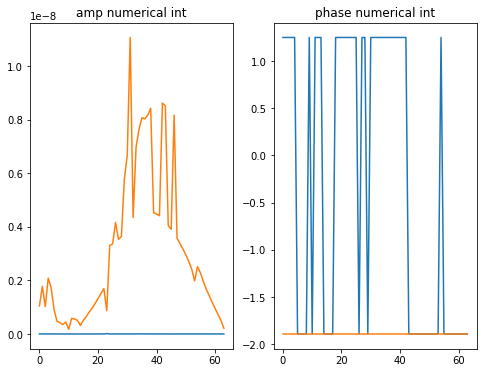

In [696]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(np.abs(output_field))
plt.title('amp numerical int')
plt.subplot(1,2,2)
plt.plot(np.unwrap(np.angle((output_field))))
plt.title('phase numerical int')

Seems to not work -- need to delve deeper into Rayliegh Sommerfield Integral approach

In [702]:
# Fourier method non-conv
input_space = np.linspace(-pitch*len(marg_x)/2,pitch*len(marg_x)/2,len(marg_x))
quad_phase = np.exp(1j*pi/(lambda_*z)*input_space**2)
output_spatial_bandwidth = lambda_*z/(2*pitch)+len(marg_x)*pitch
output_space = np.linspace(-output_spatial_bandwidth/2,output_spatial_bandwidth/2,len(marg_x))
output_field = np.fft.fftshift(np.fft.fft(np.fft.fftshift(marg_x*quad_phase)))*np.exp(1j*2*pi*z/lambda_) * np.exp(1j*pi/(lambda_*z)*(output_space)**2)

Text(0.5, 1.0, 'phase fourier non-conv')

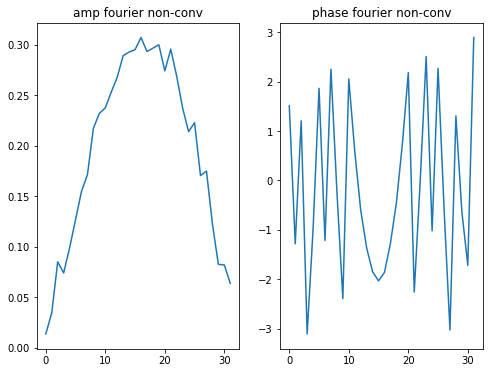

In [704]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.plot(np.abs(output_field))
plt.title('amp fourier non-conv')
plt.subplot(1,2,2)
plt.plot(np.angle((output_field)))
plt.title('phase fourier non-conv')

In [700]:
# Direct fourier transf